In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sales_df = pd.read_csv('out/sales_aggregated.csv', index_col=0)

In [3]:
sales_df = sales_df.transpose()

In [4]:
sales_df.columns.name = None
sales_df = sales_df.rename_axis("Date")
sales_df = sales_df.reset_index()

sales_df.head()

,Date,SCHAB Z KOŚCIĄ,SCHAB BEZ KOŚCI,KARCZEK BEZ KOŚCI,SZYNKA Z KOŚCIA,SZYNKA BEZ KOŚCI,ŁOPATKA Z KOŚCIA,ŁOPATKA BEZ KOŚCI,ŁOPATKA MIELONA,ŻEBERKO,...,SALCESON,KASZANKA,PASZTETOWA,BOCZEK WEDZ-GOT,BOCZEK WĘDZONY,PODGZRDLE WĘDZONE,GOLONKA WĘDZONA,ŻEBERKA WĘDZONE,PARÓWKI,WĘDLINY
0,01_2015,181.920,192.732,156.977,0.00,177.450,280.98,157.570,244.28,250.190,...,42.47,97.598,34.470,3.490,87.550,33.40,0.72,2.24,0.00,29.580
1,02_2015,174.210,179.310,171.419,2.84,213.170,246.35,165.918,211.50,263.570,...,41.65,66.740,20.947,16.515,56.850,18.72,0.96,0.00,0.00,27.040
2,03_2015,391.492,331.325,301.939,62.11,385.080,378.56,377.568,392.25,435.851,...,64.70,107.050,33.805,49.825,82.562,27.23,2.14,0.91,31.61,34.290
3,04_2015,330.390,177.610,228.790,26.91,219.120,450.51,218.150,361.44,300.840,...,51.75,79.780,33.255,44.860,58.500,75.57,0.00,0.00,37.69,28.973
4,05_2015,459.240,159.792,272.260,33.65,215.273,279.39,257.570,363.41,387.389,...,49.72,103.800,51.710,53.247,77.560,39.19,0.92,3.48,14.22,43.280


### Melting the data to a better format

In [5]:
sales_df = sales_df.melt(id_vars=["Date"], var_name='Product', value_name='Sales in kg')

In [6]:
sales_df

,Date,Product,Sales in kg
0,01_2015,SCHAB Z KOŚCIĄ,181.920
1,02_2015,SCHAB Z KOŚCIĄ,174.210
2,03_2015,SCHAB Z KOŚCIĄ,391.492
3,04_2015,SCHAB Z KOŚCIĄ,330.390
4,05_2015,SCHAB Z KOŚCIĄ,459.240
...,...,...,...
5395,08_2023,WĘDLINY,513.860
5396,09_2023,WĘDLINY,580.460
5397,10_2023,WĘDLINY,691.890
5398,11_2023,WĘDLINY,622.950


### Feature engineering, encoding

In [7]:
def extract_season(value):
    month = str(value).split('_')[0]
    if month in ['12', '01', '02']: return "WIN"
    elif month in ['03', '04', '05']: return "SPR"
    elif month in ['06', '07', '08']: return "SUM"
    elif month in ['09', '10', '11']: return "FAL"

def include_holidays(value):
    month = str(value).split('_')[0]
    if month in ['03', '04']: return "EASTER"
    if month == "12": return "CHRISTMAS"


def feature_engineering(df):
    df['Holiday'] = df['Date'].apply(include_holidays)
    df['Season'] = df['Date'].apply(extract_season)
    return df
    
    
def encoding(df):
    return pd.get_dummies(df, columns=['Holiday', 'Season'], dtype=int)


    
    

sales_df = feature_engineering(sales_df.copy())
sales_df = encoding(sales_df.copy())

sales_df

,Date,Product,Sales in kg,Holiday_CHRISTMAS,Holiday_EASTER,Season_FAL,Season_SPR,Season_SUM,Season_WIN
0,01_2015,SCHAB Z KOŚCIĄ,181.920,0,0,0,0,0,1
1,02_2015,SCHAB Z KOŚCIĄ,174.210,0,0,0,0,0,1
2,03_2015,SCHAB Z KOŚCIĄ,391.492,0,1,0,1,0,0
3,04_2015,SCHAB Z KOŚCIĄ,330.390,0,1,0,1,0,0
4,05_2015,SCHAB Z KOŚCIĄ,459.240,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
5395,08_2023,WĘDLINY,513.860,0,0,0,0,1,0
5396,09_2023,WĘDLINY,580.460,0,0,1,0,0,0
5397,10_2023,WĘDLINY,691.890,0,0,1,0,0,0
5398,11_2023,WĘDLINY,622.950,0,0,1,0,0,0


### Transforming the data to fit the model

In [8]:
# converting Data column to pandas datetime and setting it as the index
sales_df['Date'] = pd.to_datetime(sales_df['Date'], format='%m_%Y')
sales_df['Date'] = sales_df['Date'].dt.to_period('M') 
sales_df.set_index('Date', inplace=True)

In [25]:
#extracting single product sales
single_product_sales = sales_df[sales_df['Product'] == 'SCHAB Z KOŚCIĄ']

single_product_sales

,Product,Sales in kg,Holiday_CHRISTMAS,Holiday_EASTER,Season_FAL,Season_SPR,Season_SUM,Season_WIN
Date,,,,,,,,
2015-01,SCHAB Z KOŚCIĄ,181.920,0,0,0,0,0,1
2015-02,SCHAB Z KOŚCIĄ,174.210,0,0,0,0,0,1
2015-03,SCHAB Z KOŚCIĄ,391.492,0,1,0,1,0,0
2015-04,SCHAB Z KOŚCIĄ,330.390,0,1,0,1,0,0
2015-05,SCHAB Z KOŚCIĄ,459.240,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
2023-08,SCHAB Z KOŚCIĄ,206.840,0,0,0,0,1,0
2023-09,SCHAB Z KOŚCIĄ,214.360,0,0,1,0,0,0
2023-10,SCHAB Z KOŚCIĄ,236.590,0,0,1,0,0,0


### Checking if the data is stationary

<Axes: xlabel='Date', ylabel='Sales in kg'>

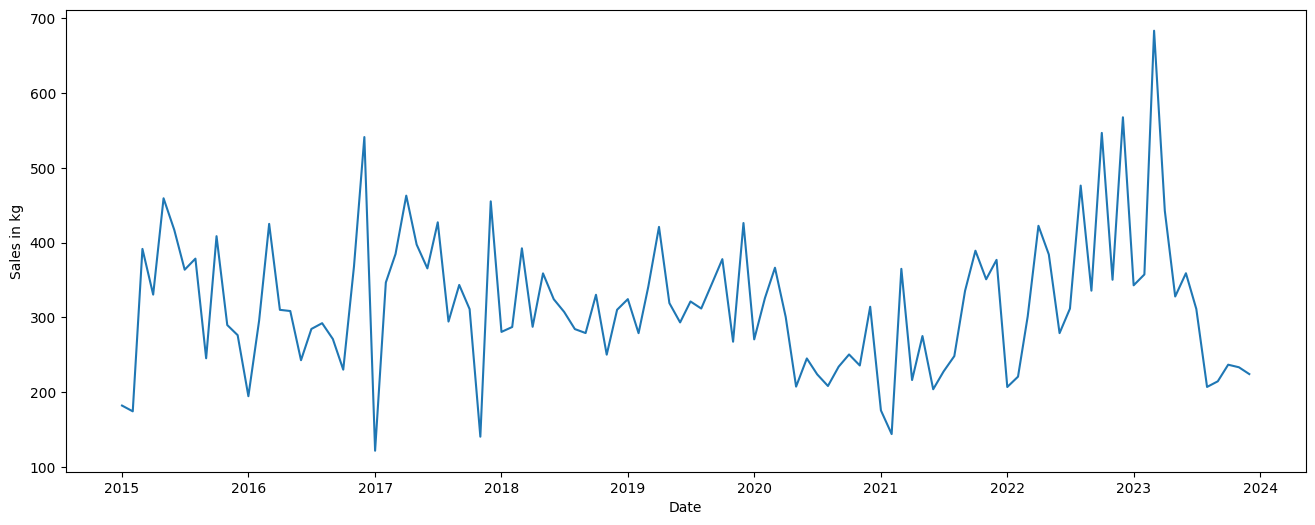

In [26]:
tmp = single_product_sales.copy()
tmp.index = tmp.index.to_timestamp()


plt.figure(figsize=(16, 6))
sns.lineplot(data=tmp['Sales in kg'])

In [28]:
from statsmodels.tsa.stattools import adfuller

res = adfuller(single_product_sales['Sales in kg'])
print(f'ADF statistic (critical value):              {res[0]}')
print(f'p-value:                                     {res[1]}')
print(f'number of lags used in regression::          {res[2]}')
print(f'number of observations used in the analisys: {res[3]}')
print(f'Critical values (t-values):                  {res[4]}')


ADF statistic (critical value):              -3.7510839938674554
p-value:                                     0.0034493686371805934
number of lags used in regression::          2
number of observations used in the analisys: 105
Critical values (t-values):                  {'1%': np.float64(-3.4942202045135513), '5%': np.float64(-2.889485291005291), '10%': np.float64(-2.5816762131519275)}


### **Notes and observations**
-  **Null hypothesis** - it's saying that NON stationary data exists in the series
-  **Alternative hypothesis** - it's saying that stationary data exists in the series

__What we do to test the hypothesis, is :__
1. Compare the critical value to each t-value, and if its smaller, then we can reject the null hypothesis <br/>
    _(In this case -3.75 < -3.49, -2.88, -2.58)_
2. Establish a significance level, for example 5%, and check if the p-value is significant compared to it. If it isn't then we have a stronger reason to reject the null hypothesis <br/>
    _(In this case 0.003 < 0.05)_

##### __SUMMARY__ <br/>
Observations show that we can confidently reject the null hypothesis, and mark the data as __STATIONARY__

----

### Splitting the data

In [31]:
endog_y = single_product_sales['Sales in kg']
exog_X = single_product_sales.drop(columns=[y.name, 'Product'])

exog_X

,Holiday_CHRISTMAS,Holiday_EASTER,Season_FAL,Season_SPR,Season_SUM,Season_WIN
Date,,,,,,
2015-01,0,0,0,0,0,1
2015-02,0,0,0,0,0,1
2015-03,0,1,0,1,0,0
2015-04,0,1,0,1,0,0
2015-05,0,0,0,1,0,0
...,...,...,...,...,...,...
2023-08,0,0,0,0,1,0
2023-09,0,0,1,0,0,0
2023-10,0,0,1,0,0,0


### Testing the model
#### TO DO:
- research about ARIMA and SARIMA
- engineer more features


In [32]:
import statsmodels.api as sm

sarimax_model = sm.tsa.SARIMAX(endog=endog_y, exog=exog_X, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))


In [34]:
results = sarimax_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         Sales in kg   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -569.180
Date:                             Thu, 21 Nov 2024   AIC                           1158.360
Time:                                     08:36:17   BIC                           1183.899
Sample:                                 01-31-2015   HQIC                          1168.679
                                      - 12-31-2023                                         
Covariance Type:                               opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Holiday_CHRISTMAS     0.0181   4.12e+04   4.39e-07      1.000   -8.08e+04    8.08e+04
Holiday_EASTER        0.0017   1.21e+04   1.42e-07      1.000   -2.37e+04    2.37e+04
Season_FAL           -0.0023   3.16e+04  -7.21e-08      1.000   -6.18e+04    6.18e+04
Season_SPR           -0.0022   4.09e+04  -5.37e-08      1.000   -8.01e+04    8.01e+04
Season_SUM           -0.0050   3.75e+04  -1.32e-07      1.000   -7.35e+04    7.35e+04
Season_WIN            0.0176   6.36e+04   2.77e-07      1.000   -1.25e+05    1.25e+05
ar.L1                -0.1835      0.166     -1.104      0.269      -0.509       0.142
ma.L1                -0.5054      0.140     -3.597      0.000      -0.781      -0.230
ar.S.L12             -0.5787      0.097     -5.992      0.000      -0.768      -0.389
sigma2             8861.7503   1474.293      6.011      0.000    5972.190    1.18e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.78   Prob(JB):                         0.88
Heteroskedasticity (H):               1.11   Skew:                             0.11
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Forecast with past exog

In [66]:
forecast1 = results.get_forecast(steps=6, exog=exog_X.tail(6))
forecast_df1 = forecast1.summary_frame()
forecast_df1

Sales in kg,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-01,100.861330,94.136870,-83.643544,285.366205
2024-02,102.165088,98.589064,-91.065927,295.396104
2024-03,288.591360,106.847053,79.174986,498.007735
2024-04,256.784429,113.744316,33.849665,479.719192
2024-05,186.341349,120.377072,-49.593376,422.276075
2024-06,138.592662,126.640145,-109.617460,386.802784


### Forecast with future exog

In [69]:
future_exog = pd.DataFrame({
    'Holiday_CHRISTMAS': [0, 0, 0, 0, 0, 0], 
    'Holiday_EASTER': [0, 0, 1, 0, 0, 0], 
    'Season_FAL': [0, 0, 0, 0, 0, 0], 
    'Season_SPR': [0, 0, 1, 1, 1, 0],
    'Season_SUM': [0, 0, 0, 0, 0, 1], 
    'Season_WIN': [1, 1, 0, 0, 0, 0]
}, index=pd.date_range(start='2024-01-01', periods=6, freq='M'))

forecast2 = results.get_forecast(steps=6, exog=future_exog)
forecast_df2 = forecast2.summary_frame()
forecast_df2

C:\Users\damia\AppData\Local\Temp\ipykernel_20356\3477029066.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  }, index=pd.date_range(start='2024-01-01', periods=6, freq='M'))


Sales in kg,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-01,100.883911,94.136870,-83.620964,285.388785
2024-02,102.187669,98.589064,-91.043347,295.418684
2024-03,288.593167,106.847053,79.176792,498.009542
2024-04,256.784511,113.744316,33.849748,479.719275
2024-05,186.341432,120.377072,-49.593293,422.276157
2024-06,138.551973,126.640145,-109.658149,386.762096


### Comparing forecasts to actual sales

In [ ]:
sales = [152.46, 148.90, 251.85, 158.24, 159.62, 165.41, ]
dates = forecast_df1.index.tolist()

actual_sales = pd.DataFrame(index=dates, data=sales, columns=['Actual sales'])
actual_sales['Forecast with past exog'] = forecast_df1['mean']
actual_sales['Forecast with future exog'] = forecast_df2['mean']

actual_sales.index = actual_sales.index.to_timestamp()
actual_sales = actual_sales.reset_index()

actual_sales = actual_sales.melt(id_vars=['index'], var_name='Type of sales', )
actual_sales

,index,Type of sales,value
0,2024-01-01,Actual sales,152.460000
1,2024-02-01,Actual sales,148.900000
2,2024-03-01,Actual sales,251.850000
3,2024-04-01,Actual sales,158.240000
4,2024-05-01,Actual sales,159.620000
5,2024-06-01,Actual sales,165.410000
6,2024-01-01,Forecast with past exog,100.861330
7,2024-02-01,Forecast with past exog,102.165088
8,2024-03-01,Forecast with past exog,288.591360
9,2024-04-01,Forecast with past exog,256.784429


<Axes: xlabel='index', ylabel='value'>

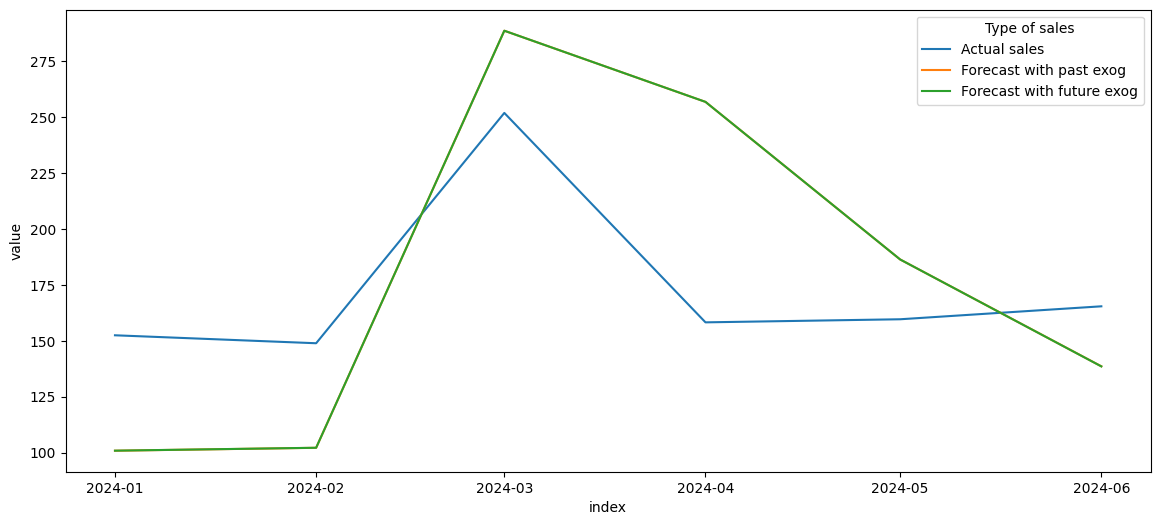

In [112]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=actual_sales, x='index', y='value', hue='Type of sales')